# Mnist vision transformer

**Dataset**: mnist (🤗)

The idea here is that we get to probe how the size of the dataset effects the model performance on a high constrained and high quality dataset. 

In [12]:
import random

import datasets
from datasets import load_dataset, load_metric, DatasetDict
import numpy as np
from PIL import ImageDraw, Image
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments, Trainer
import torch
from tqdm import tqdm

In [4]:
DATASET_NAME = "mnist"
mnist_ds = datasets.load_dataset(DATASET_NAME)

print(f"Train: {len(mnist_ds['train'])}")
print(f"Test: {len(mnist_ds['test'])}")
ex = mnist_ds['train'][500]
image = ex['image']
image

Generating test split: 100%|██████████| 10000/10000 [00:02<00:00, 4874.12 examples/s]


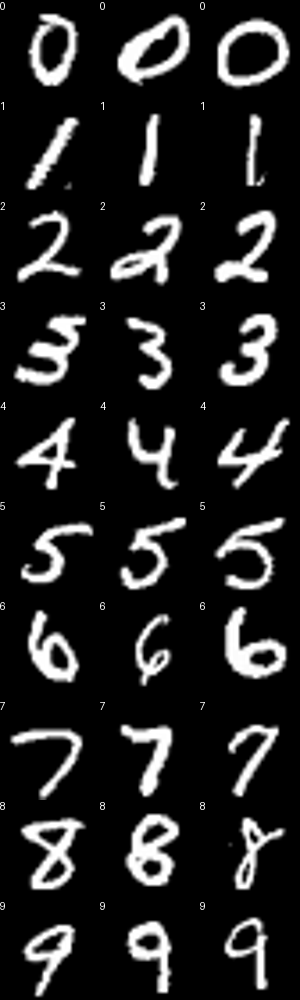

In [40]:
def show_examples(ds, seed: int = 1234, examples_per_class: int = 3, size=(100, 100)):
    w, h = size
    labels = ds['train'].features['label'].names
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)

    for label_id, label in enumerate(labels):

        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = ds['train'].filter(lambda ex: ex['label'] == label_id).shuffle(seed).select(range(examples_per_class))

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255))

    return grid

show_examples(mnist_ds, seed=random.randint(0, 1337), examples_per_class=3)

In [10]:
# Create validation set
train_ds = mnist_ds["train"]
split = int(2/7 * len(train_ds))
validation_dataset = train_ds.select(range(split))
train_dataset = train_ds.select(range(split, len(train_ds)))
mnist_ds["validation"] = validation_dataset
mnist_ds["train"] = train_dataset

# Now dataset has train, validation, and test splits
print(mnist_ds)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 42858
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 17142
    })
})


In [18]:
# Downsample before vision transformer training
TOTAL_DATASET_SIZE = 70000
DOWN_SAMPLE_SIZE = 1000
train_downsample_len = int(0.5 * DOWN_SAMPLE_SIZE)
validation_downsample_len = int(0.2 * DOWN_SAMPLE_SIZE)
test_downsample_len = int(0.3 * DOWN_SAMPLE_SIZE)

downsampled_mnist_ds = DatasetDict()
split_start_index = 0
for split, split_sample_size in zip(["train", "validation", "test"], [train_downsample_len, validation_downsample_len, test_downsample_len]):
    downsampled_mnist_ds[split] = mnist_ds[split].select(
        range(split_start_index, split_start_index + split_sample_size)
    )
    split_start_index += split_sample_size

print("Dataset structure:")
print(downsampled_mnist_ds)


Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 500
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 200
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 300
    })
})


In [60]:
model_name_or_path = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_name_or_path)
processor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [72]:
def process_example(example):
    inputs = processor(example['image'], return_tensors='pt')
    inputs['labels'] = example['label']
    return inputs

def transform(example_batch):
    processed_images = []
    for image in example_batch['image']:
        image_np = np.array(image)
        rgb_image = np.repeat(image_np[:, :, np.newaxis], 3, axis=2)
        processed_images.append(rgb_image)

    inputs = processor(processed_images, return_tensors='pt')
    inputs['labels'] = example_batch['label']
    return inputs

prepared_ds = downsampled_mnist_ds.with_transform(transform)

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

In [73]:
labels = downsampled_mnist_ds['train'].features['label'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

training_args = TrainingArguments(
  output_dir="./mnist-1k",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=False,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=processor,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [74]:
print("Pre-training evaluation score:")
metrics = trainer.evaluate(prepared_ds['validation'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

100%|██████████| 25/25 [00:36<00:00,  1.47s/it]

***** eval metrics *****
  eval_accuracy           =       0.05
  eval_loss               =     2.3143
  eval_runtime            = 0:00:38.35
  eval_samples_per_second =      5.214
  eval_steps_per_second   =      0.652


In [75]:
# Warning: This cell took ~90mins to run on my mac 13" Pro (x86)
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

  8%|▊         | 10/128 [02:31<24:03, 12.23s/it]

{'loss': 2.1658, 'learning_rate': 0.000184375, 'epoch': 0.31}


 16%|█▌        | 20/128 [04:15<18:37, 10.35s/it]

{'loss': 1.6959, 'learning_rate': 0.00016875, 'epoch': 0.62}


 23%|██▎       | 30/128 [05:54<15:23,  9.43s/it]

{'loss': 1.237, 'learning_rate': 0.000153125, 'epoch': 0.94}


 31%|███▏      | 40/128 [07:23<13:47,  9.41s/it]

{'loss': 0.8495, 'learning_rate': 0.0001375, 'epoch': 1.25}


 39%|███▉      | 50/128 [09:02<12:32,  9.65s/it]

{'loss': 0.5745, 'learning_rate': 0.00012187500000000001, 'epoch': 1.56}


 47%|████▋     | 60/128 [10:37<11:04,  9.77s/it]

{'loss': 0.4345, 'learning_rate': 0.00010625000000000001, 'epoch': 1.88}


 55%|█████▍    | 70/128 [12:06<08:47,  9.10s/it]

{'loss': 0.2848, 'learning_rate': 9.062500000000001e-05, 'epoch': 2.19}


 62%|██████▎   | 80/128 [13:36<07:20,  9.18s/it]

{'loss': 0.2422, 'learning_rate': 7.500000000000001e-05, 'epoch': 2.5}


 70%|███████   | 90/128 [15:08<05:52,  9.27s/it]

{'loss': 0.2058, 'learning_rate': 5.9375e-05, 'epoch': 2.81}


 78%|███████▊  | 100/128 [16:49<04:53, 10.48s/it]

{'loss': 0.1884, 'learning_rate': 4.375e-05, 'epoch': 3.12}


                                                 
 78%|███████▊  | 100/128 [17:30<04:53, 10.48s/it]

{'eval_loss': 0.2384464293718338, 'eval_accuracy': 0.975, 'eval_runtime': 41.1062, 'eval_samples_per_second': 4.865, 'eval_steps_per_second': 0.608, 'epoch': 3.12}


 86%|████████▌ | 110/128 [19:17<03:15, 10.86s/it]

{'loss': 0.1634, 'learning_rate': 2.8125000000000003e-05, 'epoch': 3.44}


 94%|█████████▍| 120/128 [20:49<01:15,  9.49s/it]

{'loss': 0.1514, 'learning_rate': 1.25e-05, 'epoch': 3.75}


100%|██████████| 128/128 [22:04<00:00, 10.34s/it]


{'train_runtime': 1324.1002, 'train_samples_per_second': 1.51, 'train_steps_per_second': 0.097, 'train_loss': 0.6491917483508587, 'epoch': 4.0}
***** train metrics *****
  epoch                    =        4.0
  train_loss               =     0.6492
  train_runtime            = 0:22:04.10
  train_samples_per_second =       1.51
  train_steps_per_second   =      0.097


In [76]:
metrics = trainer.evaluate(prepared_ds['validation'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

100%|██████████| 25/25 [00:35<00:00,  1.42s/it]

***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =      0.975
  eval_loss               =     0.2384
  eval_runtime            = 0:00:37.68
  eval_samples_per_second =      5.307
  eval_steps_per_second   =      0.663


In [77]:
metrics = trainer.evaluate(prepared_ds['test'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

100%|██████████| 38/38 [00:55<00:00,  1.46s/it]

***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.9467
  eval_loss               =     0.2993
  eval_runtime            = 0:00:56.91
  eval_samples_per_second =      5.271
  eval_steps_per_second   =      0.668
